# Project Pipeline
This notebook describes the general processing pipeline of the project. It shows a light-version pipeline of data processing on how to answer the research questions as shown in the methods in README.md step by step.

# Required package
[qwikidata](https://qwikidata.readthedocs.io/en/stable/)
[json](https://docs.python.org/3/library/json.html)
[bz2](https://docs.python.org/3/library/bz2.html)
[pandas](https://pandas.pydata.org/)
[nltk](https://www.nltk.org/)
[gensim](https://radimrehurek.com/gensim/)

# Required data
[wikidata dump](https://dumps.wikimedia.org/wikidatawiki/entities/)
[quotebank](https://zenodo.org/record/4277311#.YY6Nj2DMJm8)

In [58]:
import pandas as pd
import gensim
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem import PorterStemmer as ps
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import networkx as nx
import matplotlib.pyplot as plt

In [10]:
QUOTEBANK_POLITICIANS_USA_MAPPED = 'quotebank_politicians_USA_mapped.json.bz2'
sample_data = pd.read_json(QUOTEBANK_POLITICIANS_USA_MAPPED, lines=True, compression='bz2')

## Task 1 Network Models

In this part we plot a simple network model to prove the feasiblity of the proposal and present a simple show case.

In [55]:
QUOTEBANK_POLITICIANS_USA_MAPPED = 'quotebank_politicians_USA_mapped.json.bz2'
df = pd.read_json(QUOTEBANK_POLITICIANS_USA_MAPPED, lines=True, compression='bz2' )

In [56]:
trump_mentions = df['qids'].str[0]=='Q22686'
biden_mentions = df['qids'].str[0]=='Q6279'
bernie_mentions = df['qids'].str[0]=='Q359442'
trump_mentioned = df['mentions_qids'].apply(lambda x: 'Q22686' in x)
biden_mentioned = df['mentions_qids'].apply(lambda x: 'Q6279' in x)
bernie_mentioned = df['mentions_qids'].apply(lambda x: 'Q359442' in x)

In [57]:
print(f'Trump mentioned Trump {(trump_mentions & trump_mentioned).sum()} times in 2020 US data.')
print(f'Trump mentioned Biden {(trump_mentions & biden_mentioned).sum()} times in 2020 US data.')
print(f'Trump mentioned Bernie {(trump_mentions & bernie_mentioned).sum()} times in 2020 US data.')
print(f'Biden mentioned Trump {(biden_mentions & trump_mentioned).sum()} times in 2020 US data.')
print(f'Biden mentioned Biden {(biden_mentions & biden_mentioned).sum()} times in 2020 US data.')
print(f'Biden mentioned Bernie {(biden_mentions & bernie_mentioned).sum()} times in 2020 US data.')
print(f'Bernie mentioned Trump {(bernie_mentions & trump_mentioned).sum()} times in 2020 US data.')
print(f'Bernie mentioned Biden {(bernie_mentions & biden_mentioned).sum()} times in 2020 US data.')
print(f'Bernie mentioned Bernie {(bernie_mentions & bernie_mentioned).sum()} times in 2020 US data.')

Trump mentioned Trump 1604 times in 2020 US data.
Trump mentioned Biden 275 times in 2020 US data.
Trump mentioned Bernie 119 times in 2020 US data.
Biden mentioned Trump 932 times in 2020 US data.
Biden mentioned Biden 538 times in 2020 US data.
Biden mentioned Bernie 94 times in 2020 US data.
Bernie mentioned Trump 1171 times in 2020 US data.
Bernie mentioned Biden 402 times in 2020 US data.
Bernie mentioned Bernie 173 times in 2020 US data.


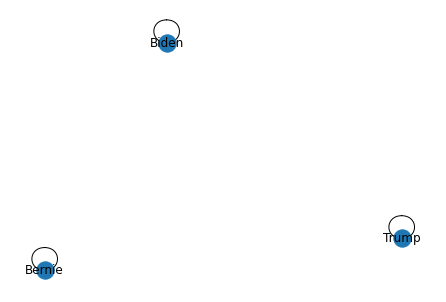

In [60]:

# Build a dataframe with 4 connections
df = pd.DataFrame({ 'from':['Trump', 'Biden', 'Bernie'], 'to':['Trump', 'Biden', 'Bernie']})
 
# Build your graph
G=nx.from_pandas_edgelist(df, 'from', 'to')
 
# Plot it
nx.draw(G, with_labels=True)
plt.show()

## Task 2 Sentiment Analysis

In this task we plan to do sentiment analysis on the quotation mentions and draw a new network graph showing the sentiment when a politician mentions or is mentioned by another politician. To prove the feasibility of the task, a small scale sentiment analysis is done on US quotation mentions in 2020 with the SentimentIntensityAnalyzer in package nltk, which is pretrained with more than [100 datasets](https://www.nltk.org/nltk_data/).

First we load the US politician mentions in 2020 and create a list out of the mentions.

In [18]:
QUOTEBANK_POLITICIANS_USA_MAPPED = 'quotebank_politicians_USA_mapped.json.bz2'
sample_data = pd.read_json(QUOTEBANK_POLITICIANS_USA_MAPPED, lines=True, compression='bz2')
sentences = []
sentences.extend(sample_data['quotation'].tolist())

We print mentions with either a positive or negative emotion with their scores. (sentiment score > 0.5)

In [39]:
for sentence in sentences:
...    sid = SentimentIntensityAnalyzer()
...    print(sentence)
...    ss = sid.polarity_scores(sentence)
...    for k in sorted(ss):
...        print('{0}: {1}, '.format(k, ss[k]), end='')
...    print()

but [ President ] Trump (was) eager to make a symbol of the Army officer sooner after the Senate acquitted him of the impeachment charges approved by House Democrats.
compound: 0.7783, neg: 0.078, neu: 0.645, pos: 0.277, 
Even if it's all true, exactly in the worst-case scenario as John Bolton may put it, it doesn't really change the facts much, if at all. For me, I also don't think I'd really learn anything new from him, because we already know that the president was concerned about Biden's role, when Joe Biden was vice president of the United States, and a possible corrupt activity in Ukraine. So, if it's further proof of it, so what? We already know about it.
compound: 0.6808, neg: 0.0, neu: 0.933, pos: 0.067, 
I enjoy your analysis and instruction on polling. I hope in the future you will continue with more pithy insight on topics such as polling registered voters versus `likely voters,' polling sample size, and polling sample demographics. In regards to President Trump I believe o

Bondi and the other Trump lawyers spend most of the day savaging the Bidens (as expected)... it become crystal clear to me: Trump is trying to use the trial to do what Ukraine wouldn't -- destroy his political rivals.
compound: 0.6652, neg: 0.0, neu: 0.872, pos: 0.128, 
Both Vice President Biden and former Mayor Pete have helped shape our economy. Joe Biden helped save the auto industry, which revitalized the economy of the Midwest, and led the passage and the implementation of the Recovery Act, saving our economy from a depression,
compound: -0.128, neg: 0.077, neu: 0.856, pos: 0.067, 
Can a woman beat Donald Trump? Look at the men on this stage. Collectively, they have lost 10 elections. The only people on this stage who have won every single election that they've been in are the women... and the only person on this stage who has beaten an incumbent Republican anytime in the past 30 years is me.
compound: -0.1027, neg: 0.08, neu: 0.862, pos: 0.058, 
he has dedicated his life to fight

Jennifer, Richard, you just told me the story about how if you'd taken that small raise, if you did a little more overtime, you would have lost all of the benefits of Care 4 Kids, you would have lost money doing it, and instead we made it easier for middle class families to afford it so that your beautiful daughter, you'll know, will have a great place, a safe place, while you're hard at work,
compound: 0.9409, neg: 0.068, neu: 0.706, pos: 0.225, 
Lowering the cost of healthcare and improving the health of Americans has been a key priority of President Trump during his first three years in office, and tonight, he laid out the results that his leadership has produced... The President is fulfilling his promise to protect what works in our healthcare system and make it better, and more success is still to come.
compound: 0.9117, neg: 0.028, neu: 0.771, pos: 0.201, 
President Trump viscerally understands that the toppling of Saddam Hussein made Iran stronger. Soleimani, like Hussein, was a

We can also more strictly constrain the sentiment score to pick out mentions with only strong emotions. (sentiment score > 0.7)

This will result in fewer results, but more accurate in sentiment classification in general.

In [51]:
for sentence in sentences:
    sid = SentimentIntensityAnalyzer()
    ss = sid.polarity_scores(sentence)
#     print(ss)
    if(ss['pos']> 0.7 or ss['neg']> 0.7):
        print(sentence)
        print(ss)
        #print('{0}: {1}, '.format(k, ss[k]), end='')
#     for k in sorted(ss):
        
#     print()

hopeful & optimistic Trump.
{'neg': 0.0, 'neu': 0.152, 'pos': 0.848, 'compound': 0.6808}
Biden supports free college. Bernie supports free college.
{'neg': 0.0, 'neu': 0.256, 'pos': 0.744, 'compound': 0.891}
Acquitted! Trump Acquitted.
{'neg': 0.0, 'neu': 0.189, 'pos': 0.811, 'compound': 0.5093}
a great win for Bernie Sanders.
{'neg': 0.0, 'neu': 0.275, 'pos': 0.725, 'compound': 0.836}
Trump's irresponsible trade wars.
{'neg': 0.765, 'neu': 0.235, 'pos': 0.0, 'compound': -0.7579}
Trump is guilty as hell. I don't care.
{'neg': 0.715, 'neu': 0.285, 'pos': 0.0, 'compound': -0.8758}
will defeat Trump's hate and greed.
{'neg': 0.758, 'neu': 0.242, 'pos': 0.0, 'compound': -0.8555}
Trump kills terrorist, escapes quagmire
{'neg': 0.701, 'neu': 0.171, 'pos': 0.128, 'compound': -0.8271}


## Task 3 LDA Topic Clustering

In this task we need to interpret what the politicians talk about when they are referring to another politician. We propose to do this with the help of LDA topic clustering. Here is a small example showing the feasibility and the current problems of the method.

We first defined some functions for pre-processing the quotations to extract the tokens dictionary with the help of [reference](https://towardsdatascience.com/nlp-extracting-the-main-topics-from-your-dataset-using-lda-in-minutes-21486f5aa925).

In [53]:
def lemmatize_stemming(text):\
    '''lemmatize stem the text to get key tokens'''
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))
# Tokenize and lemmatize
def preprocess(text):
    '''preprocess the quotation list and extract tokens to dictionary'''
    result=[]
    for token in gensim.utils.simple_preprocess(text) :
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
    return result

Then we instantiate the stemmer and use it to extract bag of words in each quotations.

In [28]:
stemmer = ps() #instantilize
processed_docs = []
for quotation in sample_data['quotation'].tolist():
    processed_docs.append(preprocess(quotation))
dictionary = gensim.corpora.Dictionary(processed_docs) #words into
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs] #convert to bag of words

We build an LDA clustering model to cluster bag of words into popular topics, with a pre-defined cluster number of 8.

In [48]:
lda_model =  gensim.models.LdaMulticore(bow_corpus, 
                                   num_topics = 8, 
                                   id2word = dictionary,                                    
                                   passes = 10,
                                   workers = 2)

Here is a visualisation of clustered frequent topics.

In [52]:
for idx, topic in lda_model.print_topics(-1):
    print("Topic: {} \nWords: {}".format(idx, topic ))
    print("\n")

Topic: 0 
Words: 0.121*"trump" + 0.060*"donald" + 0.039*"presid" + 0.016*"beat" + 0.015*"american" + 0.014*"defeat" + 0.012*"peopl" + 0.011*"countri" + 0.010*"iran" + 0.009*"go"


Topic: 1 
Words: 0.037*"trump" + 0.023*"presid" + 0.016*"administr" + 0.014*"state" + 0.013*"work" + 0.011*"american" + 0.009*"health" + 0.007*"continu" + 0.007*"need" + 0.006*"protect"


Topic: 2 
Words: 0.055*"obama" + 0.019*"barack" + 0.019*"say" + 0.015*"presid" + 0.013*"year" + 0.010*"administr" + 0.010*"like" + 0.007*"bush" + 0.007*"good" + 0.007*"peopl"


Topic: 3 
Words: 0.062*"biden" + 0.023*"democrat" + 0.019*"sander" + 0.018*"berni" + 0.016*"presid" + 0.015*"go" + 0.014*"think" + 0.012*"peopl" + 0.012*"candid" + 0.012*"campaign"


Topic: 4 
Words: 0.014*"sander" + 0.013*"berni" + 0.010*"senat" + 0.008*"pelosi" + 0.008*"nanci" + 0.008*"puerto" + 0.007*"romney" + 0.007*"rico" + 0.007*"support" + 0.007*"state"


Topic: 5 
Words: 0.033*"trump" + 0.032*"bloomberg" + 0.027*"mike" + 0.016*"money" + 0.015*

There is an obvious problem that clusters are centered on politician names. This is understandable because we filtered the data to pick out the quotations containing politician names. For the final project in MS3, we should prune any of the politician names from the dictionary. In this way, we expect the clusters to go into meaningful topics in the end.